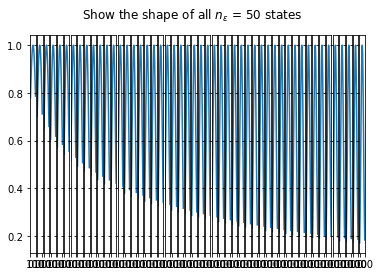

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import math
from sklearn.decomposition import PCA
import plotly.express as px
from MRA_generate import MRA_generate
from symae_model import SymAE, SymAE_Dense
from parameters import *
from latent import latent
from redatuming import redatuming
from plot_redatuming import plot_redatuming
def g(n,x):
    return math.e**(-math.sqrt(n+1)*(x-0.5)**2)
fig, axs = plt.subplots(1, ne, sharex=True, sharey=True)
for i in range(ne):
    axs[i].plot(range(d), [g(i,x/d) for x in range(d)])
plt.suptitle('Show the shape of all $n_\epsilon$ = %d states'%ne)
MRA_training = MRA_generate(d,nt,N,sigma,ne,g,replace=0)
pca_cb = PCA(n_components=2)
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=0)
MRA_training.generate_default()
MRA_pca.generate_default()
X = MRA_training.X
clear_output()
N_shifts = MRA_pca.shifts.reshape(-1,1)
N_states = np.repeat(MRA_pca.states,nt)
image_list = []
clear_output()
fig.show()

In [2]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("For epoch {:d}, loss is {:f}.".format(epoch, logs["loss"]))
        if epoch % 50 == 0:
            clear_output(wait = True)
            _,Ns = latent(model,MRA_pca)
            N_reshaped = Ns.reshape(-1,q)
            pca_N = pca_cb.fit_transform(N_reshaped)
            df = pd.DataFrame(pca_N, columns = ['1st','2nd'])
            df_states = pd.DataFrame(N_states,columns=['state']).astype('object') 
            df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
            df = pd.concat([df,df_states,df_shifts],axis=1)
            fig = px.scatter(df, x='1st', y='2nd', color='state', text='shift', title='q=%d,loss=%f'%(q,logs["loss"]))
            fig.update_layout(height=500)
            fig.show()

In [3]:
model = SymAE(N,nt,d,p,q,kernel_size,filters,dropout_rate)
#model.load_weights('./checkpoint/'+'p=3,q=3,add')
#model.load_weights('p=10,q=10,add,norm=1,ne=7')
#model.load_weights('p=10,q=10,ber,ne=50,30')
clear_output()

In [4]:
model.latentcat.drop.stddev = 0.1
model.latentcat.drop.rate = 0.5

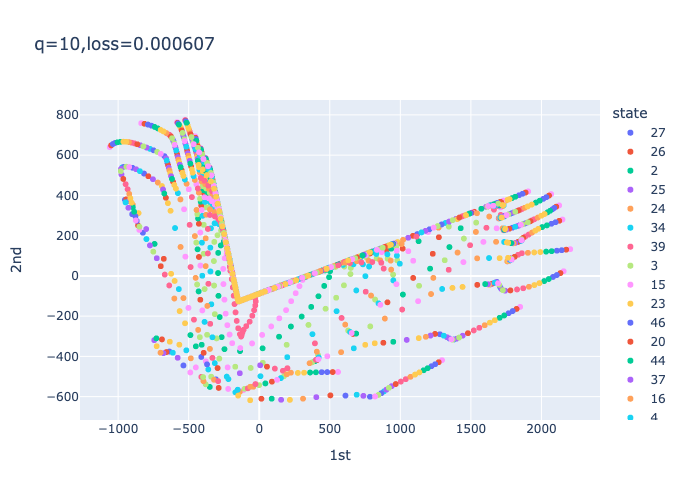

For epoch 1, loss is 0.000623.
For epoch 2, loss is 0.000655.
For epoch 3, loss is 0.000601.
For epoch 4, loss is 0.000604.
For epoch 5, loss is 0.000588.
For epoch 6, loss is 0.000606.
For epoch 7, loss is 0.000619.
For epoch 8, loss is 0.000608.
For epoch 9, loss is 0.000675.
For epoch 10, loss is 0.000650.
For epoch 11, loss is 0.000594.
For epoch 12, loss is 0.000636.
For epoch 13, loss is 0.000623.


KeyboardInterrupt: 

In [5]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
SGD = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.0,nesterov=False)
model.compile(loss='mse',optimizer=Adam)
history = model.fit(X,X,epochs=10000,verbose=0,callbacks=[CustomCallback()])

In [6]:
#model.save_weights('p=10,q=10,ber,ne=50,30')

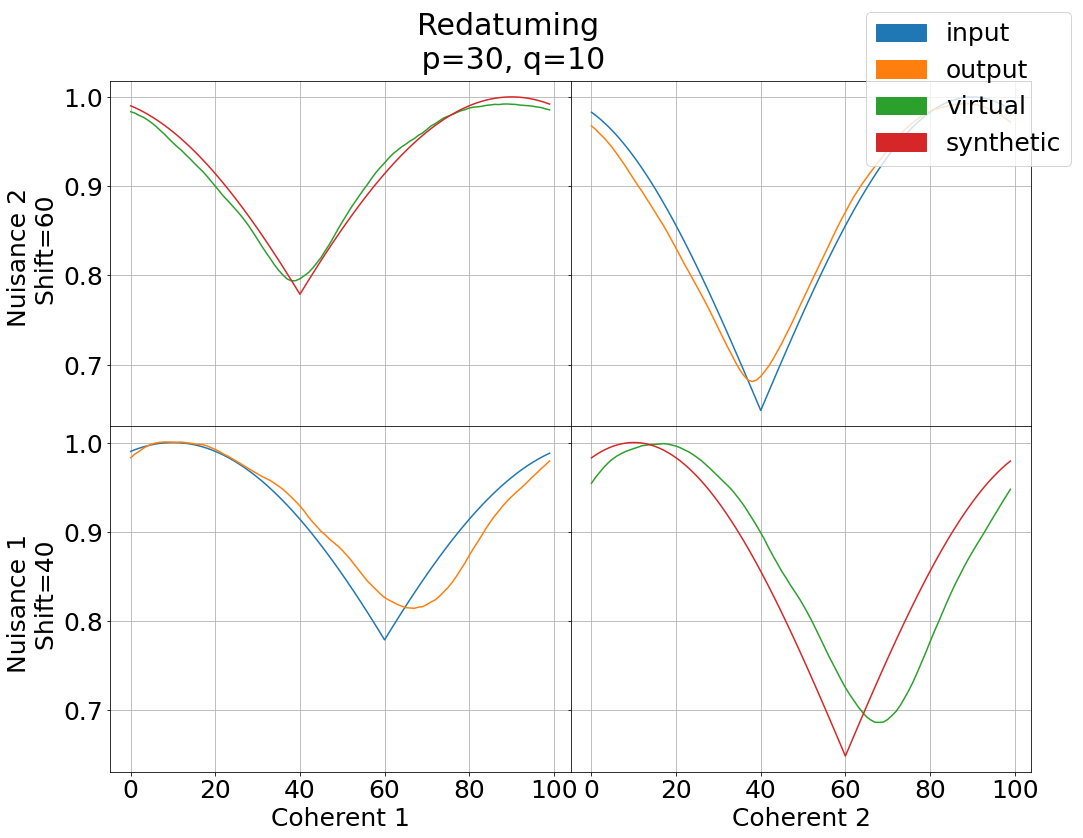

In [9]:
def find(state,nuisance):
    MRA_data = MRA_generate(d,nt,1,sigma,ne,g,replace=1)
    for i in range(1000):
        MRA_data.generate_default()
        if MRA_data.states[0] != state:
            continue
        for j in range(nt):
            if MRA_data.shifts[0][j] == nuisance:
                return MRA_data, j
MRA1, t1 = find(0,40)
MRA2, t2 = find(2,60)
redatum = redatuming(model,MRA1,MRA2,t1,t2)
clear_output()
fig = plot_redatuming(redatum)


KeyboardInterrupt



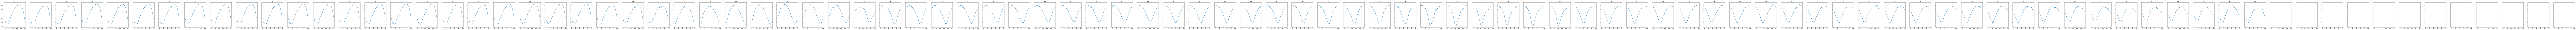

In [8]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,:]
def enc(state, shift):
    tem = np.array( [g(state, ((k+shift)%d)/d) for k in range(d)] )
    tem = tem[np.newaxis, np.newaxis, :, np.newaxis]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.encoder.predict(tem, verbose=0)
    return tem[0][0:p+q]
state_source = 0
nuisance_source = 1
fig, axs = plt.subplots(1, d, sharex=True, sharey=True, figsize=(4*d,4), dpi=40)
for i in range(d):
    coherent_code = enc(state_source, 0)[0: p]
    nuisance_code = enc(nuisance_source, i)[p: p+q]
    latent_code = np.concatenate([coherent_code, nuisance_code], axis=0)
    axs[i].plot(range(d), dec(latent_code))
    axs[i].set_title('%d'%i)
plt.suptitle('$\hat{X}_{s=%d \mapsto s=%d}$'%(nuisance_source, state_source), fontsize=50)
plt.subplots_adjust(top=0.6)
plt.show()
#fig.savefig('./plots/%dto%d'%(nuisance_source, state_source))

In [ ]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,:,0]
def enc(state, shift):
    tem = np.array( [g(state, ((k+shift)%d)/d) for k in range(d)] )
    tem = tem[np.newaxis, np.newaxis, :, np.newaxis]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.encoder.predict(tem, verbose=0)
    return tem[0][0:p+q]
state_source = 0
nuisance_source = 0
fig= plt.figure(figsize=(6,5), dpi=100)

coherent_code = enc(state_source, 0)[0: p]
nuisance_code55 = enc(nuisance_source, 55)[p: p+q]
nuisance_code56 = enc(nuisance_source, 56)[p: p+q]
nuisance_code = nuisance_code55 + nuisance_code56
nuisance_code = nuisance_code / np.linalg.norm(nuisance_code)
latent_code = np.concatenate([coherent_code, nuisance_code], axis=0)
latent_code55 = np.concatenate([coherent_code, nuisance_code55], axis=0)
latent_code56 = np.concatenate([coherent_code, nuisance_code56], axis=0)
plt.plot(range(d), dec(latent_code), label='output 55.5')
plt.plot(range(d), [g(state_source, ((k+55.5)%d)/d) for k in range(d)], label='real 55.5')
plt.plot(range(d), dec(latent_code55), label='output 55')
plt.plot(range(d), dec(latent_code56), label='output 56')

plt.legend()
plt.show()
#fig.savefig('./plots/%dto%d'%(nuisance_source, state_source))

In [ ]:
np.linalg.norm(np.array([1,1]))

In [ ]:
dim = 2
pca = PCA(n_components=dim)
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=1)
MRA_pca.generate_default()
Cs,Ns = latent(model,MRA_pca)
N_reshaped = Ns.reshape(-1,q)
N_shifts = MRA_pca.shifts.reshape(-1,1)
if dim == 3:
    pca_N = N_reshaped
    df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'][0:dim])
    df_states = pd.DataFrame(np.repeat(MRA_pca.states,nt),columns=['state']).astype('object')
    df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
    df = pd.concat([df,df_states,df_shifts],axis=1)
    #df = df[df['state']==0]
    fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='state', text='shift')
if dim ==2:
    pca_N = pca.fit_transform(N_reshaped)
    df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'][0:dim])
    df_states = pd.DataFrame(np.repeat(MRA_pca.states,nt),columns=['state']).astype('object')
    df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
    df = pd.concat([df,df_states,df_shifts],axis=1)
    fig = px.scatter(df, x='1st', y='2nd', color='state', text='shift')
fig.show()